In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
from numpy import pi

import time
import matplotlib.pyplot as plt


# Define a torch-compatible parametrized curve class (with finite difference 
# approximation of derivative. and composition operator.)
class Curve(nn.Module):
    def __init__(self, component_function_tuple):
        super(Curve, self).__init__()
        self.C = tuple(component_function_tuple)
    
    def forward(self, X):
        return torch.cat([ci(X) for ci in self.C], dim=-1)
    
    
    def derivative(self, X, h=1e-3):
        return 0.5 * ( torch.cat([ci(X + h) for ci in self.C], dim=-1) 
                      - torch.cat([ci(X - h) for ci in self.C], dim=-1) ) / h
    
    def compose(self, f):
        # TODO: Allow genereal dimension curves.
        return Curve((lambda x: self.C[0](f(x)), lambda x: self.C[1](f(x))))


# Define Q-transform class of curves.
class Qmap(nn.Module):
    def __init__(self, curve: Curve):
        super(Qmap, self).__init__()
        self.c = curve
        
    def forward(self, X, h=1e-4):
        return torch.sqrt(self.c.derivative(X, h=h).norm(dim=-1, keepdim=True)) * self.c(X)

    
    
# Define a Fourier Sine Layer    
class SineSeries(nn.Module):
    def __init__(self, N, init_scale=1.):
        super(SineSeries, self).__init__()
        self.nvec = torch.arange(1, N+1)
        
        self.weights = torch.nn.Parameter(
            init_scale * torch.rand(N, 1, requires_grad=True)
        )
        self.find_ymin()
        self.project()
        
    def forward(self, x):
        z = np.pi * self.nvec * x
        y = np.pi * self.nvec * torch.cos(z)
        z = torch.sin(z)
        
        self.ymin = torch.min(y).item()
            
        return x + z @ self.weights, 1 + y @ self.weights
    
    
    def find_ymin(self, npoints=200):
        x = torch.linspace(0, 1, npoints).unsqueeze(-1)
        _, y = self.forward(x)
        self.ymin = torch.min(y).item()
        return self.ymin
    
    
    def project(self, epsilon=1e-4):
        with torch.no_grad():
            if self.ymin < epsilon:
                self.weights *= 1 / (1 + epsilon - self.ymin)

    
    

# Simple plotting function for curves.        
def plot_curve(c: Curve, npoints=201):
    X = torch.linspace(0, 1, npoints).unsqueeze(-1)
    C = c(X)
    cx, cy = C[:, 0], C[:, 1]
    
    plt.figure()
    plt.plot(cx, cy)
    plt.show()

In [11]:

"""
Define a 2-layer reparametrization network class, with initial weight vector 0.
"""
class ReparametrizationNetwork(nn.Module):
    def __init__(self, N, q: Qmap, r: Qmap):
        super(ReparametrizationNetwork, self).__init__()
        self.layer1 = SineSeries(N, init_scale=0.)
        self.layer2 = SineSeries(N, init_scale=0.)

        self.q = q
        self.r = r
        
        
    def forward(self, X):
        Z, Y = self.layer1(X)
        Z, Y2 = self.layer2(Z)
        Y = Y2 * Y
        Q = self.q(X)
        R = self.r(Z)
        return Q, R * torch.sqrt(Y)

In [12]:
# Define Test Functions: Parametrized circle, and 2 test diffeomorphisms.
C = (lambda x: torch.cos(2*pi*x), lambda x: torch.sin(2*pi*x))
f = lambda x: 0.9 * x**2 + 0.1 * x
g = lambda t: (0.5 * torch.log(20*t+1) / torch.log(21*torch.ones(1)) 
                        + 0.25 * (1 + torch.tanh(20*(t-0.5)) / torch.tanh(21*torch.ones(1))) )


# Instantiate curves and transforms
c1 = Curve(C)
c2 = c1.compose(g)
q, r = Qmap(c2), Qmap(c1)
x = torch.linspace(0, 1, 5, requires_grad=True).unsqueeze(-1)

In [147]:
# Instantiate a 2-layer network with 5 basis functions per layer.
RN = ReparametrizationNetwork(8, q, r)


# Choos update rule (here SGD with momentum)
optimizer = optim.SGD(RN.parameters(), lr=0.0001, momentum=0.01)

# Define MSE loss function (which coinsides with a scaled version of our solution) 
# NOTE: Not a complete 1-1 correspondence with the theory, but gives a simple starting point.
loss = nn.MSELoss()


tic = time.time()

# Initialize node placement
x = torch.linspace(0, 1, 1024, requires_grad=True).unsqueeze(-1)

for i in range(300):    
    # Set gradient buffers to zero.
    optimizer.zero_grad()
    
    # Find current reparametrized Q-maps
    Q, R = RN(x)
    
    # Compute loss, and perform a backward pass and gradient step
    l = loss(Q, R)
    l.backward()
    optimizer.step()


    if i % 10 == 0:
        print('[Iter %5d] loss: %.5f' %
              (i + 1, l))
        
    # Should insert projection step here as well (has not been necessary until now)
            
toc = time.time()

print()
print(f'Finished training in {toc - tic:.5f}s')

[Iter     1] loss: 2.80092
[Iter    11] loss: 1.64500
[Iter    21] loss: 1.20173
[Iter    31] loss: 0.93267
[Iter    41] loss: 0.73454
[Iter    51] loss: 0.59748
[Iter    61] loss: 0.49249
[Iter    71] loss: 0.40489
[Iter    81] loss: 0.33138
[Iter    91] loss: 0.26996
[Iter   101] loss: 0.21900
[Iter   111] loss: 0.17699
[Iter   121] loss: 0.14254
[Iter   131] loss: 0.11437
[Iter   141] loss: 0.09141
[Iter   151] loss: 0.07276
[Iter   161] loss: 0.05768
[Iter   171] loss: 0.04556
[Iter   181] loss: 0.03588
[Iter   191] loss: 0.02822
[Iter   201] loss: 0.02220
[Iter   211] loss: 0.01753
[Iter   221] loss: 0.01393
[Iter   231] loss: 0.01118
[Iter   241] loss: 0.00910
[Iter   251] loss: 0.00755
[Iter   261] loss: 0.00639
[Iter   271] loss: 0.00553
[Iter   281] loss: 0.00490
[Iter   291] loss: 0.00444

Finished training in 1.10975s


In [148]:
x = torch.linspace(0, 1, 201).unsqueeze(-1)

Q, R = RN(x)
R = R.detach()
z, y0 = RN.layer1(x)
z, y = RN.layer2(z)
y *= y0

In [149]:
def findiff(f, h=1e-4):
    """ Return derivative function of f, based on central differences."""
    return lambda x: 0.5 * (f(x+h) - f(x-h)) / h

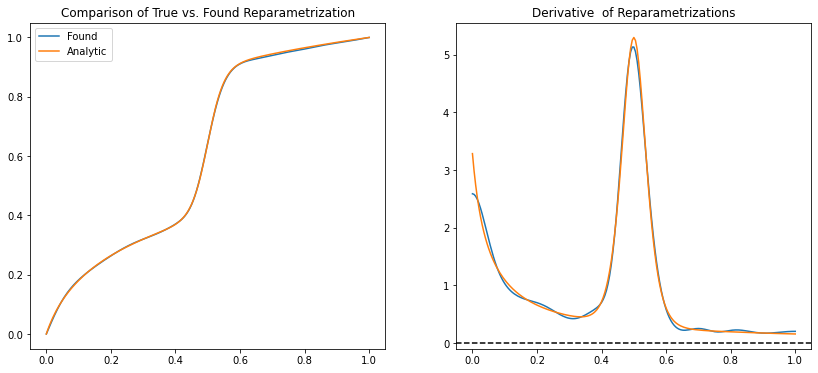

In [150]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(x, z.detach().numpy(), label="Found")
plt.plot(x, g(x), label="Analytic")
plt.title("Comparison of True vs. Found Reparametrization")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, y.detach().numpy(), label="Found")
plt.plot(x, findiff(g)(x), label="Analytic")

plt.axhline(0, ls='--', c='k')
plt.title("Derivative  of Reparametrizations")

plt.savefig("test_reparametrizations.pdf")
plt.savefig("test_reparametrizations.png")

plt.show()

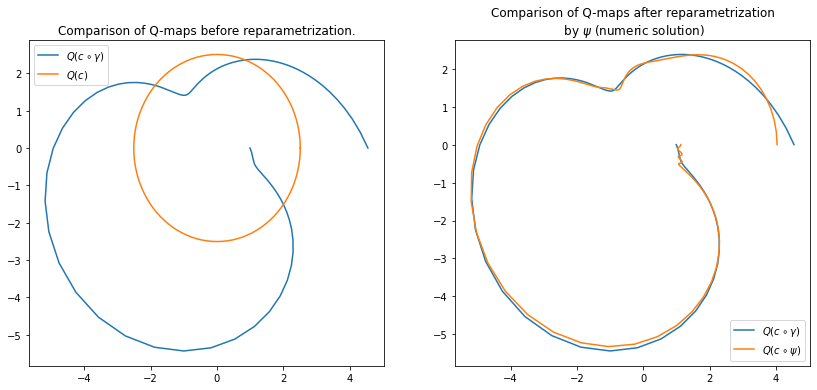

In [151]:
plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)
plt.plot(q(x)[:, 0], q(x)[:, 1], label="$Q(c \circ \gamma)$")
plt.plot(r(x)[:, 0], r(x)[:, 1], label="$Q(c)$")
plt.title("Comparison of Q-maps before reparametrization.")
plt.legend()


plt.subplot(1, 2, 2)

plt.plot(Q[:, 0], Q[:, 1], label="$Q(c \circ \gamma)$")
plt.plot(R[:, 0], R[:, 1], label="$Q(c \circ \psi)$")
plt.title("Comparison of Q-maps after reparametrization\n by $\psi$ (numeric solution)")
plt.legend()
plt.savefig("test_qmaps.pdf")
plt.savefig("test_qmaps.png")


plt.show()